## Setup and Read File

In [398]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_predict, RandomizedSearchCV, cross_val_score, cross_validate
from sklearn.metrics import (
    roc_auc_score, roc_curve, precision_recall_curve, 
    average_precision_score, brier_score_loss,
    confusion_matrix, precision_score, recall_score, f1_score
)
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OrdinalEncoder, OneHotEncoder
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.special import logit
from scipy import stats

from statsmodels.nonparametric.smoothers_lowess import lowess
from xgboost import XGBClassifier
import warnings

In [399]:
df=pd.read_parquet('/Users/huangshifeng/Desktop/stage_III_colon_surv/data/all_cases_prepared_for_ML.parquet', engine='pyarrow')

In [400]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331 entries, 0 to 330
Data columns (total 45 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Patient_ID            331 non-null    int64         
 1   Dx_Year               331 non-null    int64         
 2   Age                   331 non-null    int64         
 3   Sex                   331 non-null    int64         
 4   BMI                   327 non-null    float64       
 5   ECOG                  314 non-null    Int64         
 6   Tumor_Location        331 non-null    int64         
 7   Tumor_Location_Group  331 non-null    int64         
 8   pT_Stage              331 non-null    category      
 9   pN_Stage              331 non-null    category      
 10  AJCC_Substage         331 non-null    category      
 11  LN_Total              331 non-null    int64         
 12  LN_Positive           331 non-null    int64         
 13  LNR                 

In [401]:
features = [
    'AJCC_Substage',
    'PNI',             # 0/1
    'LNR',
    'Differentiation', # 分化程度 (Well/Mod/Poor 或 1/2/3)
]

target_col = 'edr_18m'   # 目標變數 (0/1)

In [402]:
X = df[features].copy()
y = df['edr_18m'].astype(int)

X['PNI'] = X['PNI'].astype(float)
X['Differentiation'] = X['Differentiation'].astype(float)

X = pd.get_dummies(df[features], columns=['AJCC_Substage'])

X.replace([np.inf, -np.inf], np.nan, inplace=True)

print("【資料準備完成】")
print(f"特徵矩陣形狀: {X.shape}")
print(f"缺值狀況 (補值前):\n{X.isnull().sum()[X.isnull().sum()>0]}") 
print("-" * 30)

【資料準備完成】
特徵矩陣形狀: (331, 6)
缺值狀況 (補值前):
PNI                3
Differentiation    1
dtype: int64
------------------------------


## 主模型 + Nested CV (5x3)

In [403]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.metrics import brier_score_loss, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from xgboost import XGBClassifier
import warnings

warnings.filterwarnings("ignore")

# ==========================================
# 1. 準備參數網格與 CV 設定
# ==========================================
# 完整參數網格
param_grid_full = {
    'xgb__n_estimators': [30, 50, 70, 100, 150, 200],
    'xgb__max_depth': [2, 3, 4, 5],
    'xgb__learning_rate': [0.005, 0.01, 0.02, 0.05, 0.1],
    'xgb__gamma': [0, 0.1, 0.5, 1],
    'xgb__min_child_weight': [1, 2, 3],
    'xgb__subsample': [0.6, 0.7, 0.8, 0.9],
    'xgb__colsample_bytree': [0.5, 0.6, 0.7, 0.8],
    'xgb__reg_alpha': [0, 0.1, 0.5, 1],
    'xgb__reg_lambda': [1, 1.5, 2, 3]
}

# 定義基礎 Pipeline (用於搜尋參數)
ratio = float(y.value_counts()[0] / y.value_counts()[1])
pipeline_base = Pipeline([
    ('imputer', KNNImputer(n_neighbors=5)),
    ('xgb', XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=8251,
        scale_pos_weight=ratio,
        n_jobs=1
    ))
])

# 定義 CV 切分
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=8251)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=8251)

# ==========================================
# 2. 手動執行 Nested CV + Calibration (核心邏輯)
# ==========================================
nested_auc_scores = []
best_params_list = []
y_prob_oof = np.zeros(len(y))

# 手動迴圈跑 5 個 Folds
for i, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
    print(f"Processing Fold {i+1}/5 ...")
    
    # 1. 切分資料
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # 2. 【Inner Loop 1】: 找最佳參數 (Hyperparameter Tuning)
    clf = RandomizedSearchCV(
        estimator=pipeline_base,
        param_distributions=param_grid_full,
        n_iter=5000,
        scoring='roc_auc',
        cv=inner_cv,
        n_jobs=-1,
        random_state=8251,
        verbose=0
    )
    clf.fit(X_train, y_train)
    best_params = clf.best_params_
    best_params_list.append(best_params)
    
    # 3. 【Inner Loop 2】: 訓練校準後的模型 (Calibration)
    # 使用找到的最佳參數，建立一個新的 XGB
    best_xgb = XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=8251,
        scale_pos_weight=ratio,
        n_jobs=1,
        # 將參數解包並移除 'xgb__' 前綴
        **{k.replace('xgb__', ''): v for k, v in best_params.items()}
    )
    
    # 將 XGB 包在 CalibratedClassifierCV 中
    # cv=3 表示在 Training Set 中再切 3 份來學校準 (這樣就不會漏看答案)
    calibrated_model = CalibratedClassifierCV(best_xgb, method='isotonic', cv=3)
    
    # 放入最終 Pipeline (先補值，再進校準模型)
    final_pipeline = Pipeline([
        ('imputer', KNNImputer(n_neighbors=5)),
        ('model', calibrated_model)
    ])
    
    # 4. 訓練並預測
    final_pipeline.fit(X_train, y_train)
    y_pred = final_pipeline.predict_proba(X_test)[:, 1] # 這是校準過的機率！
    
    # 5. 收集結果
    nested_auc_scores.append(roc_auc_score(y_test, y_pred))
    y_prob_oof[test_idx] = y_pred

y_prob_calib_cv = y_prob_oof
# ==========================================
# 3. 輸出結果
# ==========================================
print("\n" + "="*30)
print(f"【Nested Calibration CV 最終效能】")
print(f"Mean AUC: {np.mean(nested_auc_scores):.4f}")
print(f"95% CI: {np.mean(nested_auc_scores) - 2*np.std(nested_auc_scores):.4f} - {np.mean(nested_auc_scores) + 2*np.std(nested_auc_scores):.4f}")
print(f"各 Fold AUC: {nested_auc_scores}")

print("-" * 30)
print("【各 Fold 的最佳參數】")
for i, params in enumerate(best_params_list):
    print(f"Fold {i+1}: {params}")



Processing Fold 1/5 ...
Processing Fold 2/5 ...
Processing Fold 3/5 ...
Processing Fold 4/5 ...
Processing Fold 5/5 ...

【Nested Calibration CV 最終效能】
Mean AUC: 0.7065
95% CI: 0.5529 - 0.8601
各 Fold AUC: [0.5826210826210826, 0.7847222222222222, 0.7816358024691358, 0.6604938271604939, 0.7227866473149492]
------------------------------
【各 Fold 的最佳參數】
Fold 1: {'xgb__subsample': 0.7, 'xgb__reg_lambda': 1, 'xgb__reg_alpha': 0, 'xgb__n_estimators': 200, 'xgb__min_child_weight': 3, 'xgb__max_depth': 2, 'xgb__learning_rate': 0.02, 'xgb__gamma': 0.1, 'xgb__colsample_bytree': 0.5}
Fold 2: {'xgb__subsample': 0.9, 'xgb__reg_lambda': 1.5, 'xgb__reg_alpha': 0, 'xgb__n_estimators': 50, 'xgb__min_child_weight': 2, 'xgb__max_depth': 2, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0, 'xgb__colsample_bytree': 0.5}
Fold 3: {'xgb__subsample': 0.8, 'xgb__reg_lambda': 2, 'xgb__reg_alpha': 0.1, 'xgb__n_estimators': 30, 'xgb__min_child_weight': 2, 'xgb__max_depth': 2, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.5, 

## 建立AJCC傳統Logistic Model

In [404]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score
import warnings

# 忽略那些煩人的紅色警告
warnings.filterwarnings("ignore")

# 1. 準備只包含 AJCC 的資料
# 我們只用 AJCC_Substage 轉出來的 Dummy 變數
features_ajcc = [col for col in X.columns if 'AJCC' in col]
X_ajcc = X[features_ajcc]
y = df['edr_18m'].astype(int)

print(f"測試 AJCC Baseline (使用變數: {features_ajcc})")

# 2. 設定傳統 Logistic Regression
# C=1e9 代表幾乎不懲罰 (模擬傳統統計)，class_weight='balanced' 處理不平衡
lr = LogisticRegression(C=1e9, class_weight='balanced', solver='liblinear', random_state=8251)

# 3. 執行同樣的 5-Fold CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=8251)
ajcc_scores = cross_val_score(lr, X_ajcc, y, cv=cv, scoring='roc_auc')

# 4. 輸出結果
print("-" * 30)
print(f"【XGBoost (ML)】 Mean AUC: {np.mean(nested_auc_scores):.4f}") # 您剛剛跑出來的
print(f"【AJCC (LR)】  Mean AUC: {ajcc_scores.mean():.4f}")
print("-" * 30)
print(f"AJCC 各 Fold 分數: {ajcc_scores}")

測試 AJCC Baseline (使用變數: ['AJCC_Substage_3A', 'AJCC_Substage_3B', 'AJCC_Substage_3C'])
------------------------------
【XGBoost (ML)】 Mean AUC: 0.7065
【AJCC (LR)】  Mean AUC: 0.6883
------------------------------
AJCC 各 Fold 分數: [0.58689459 0.78703704 0.76851852 0.57484568 0.72423803]


## Figure 2 ROC/Calibration/DCA Curves

正在計算 AJCC Logistic Regression 的 CV 預測值 (用於 ROC 比較)...


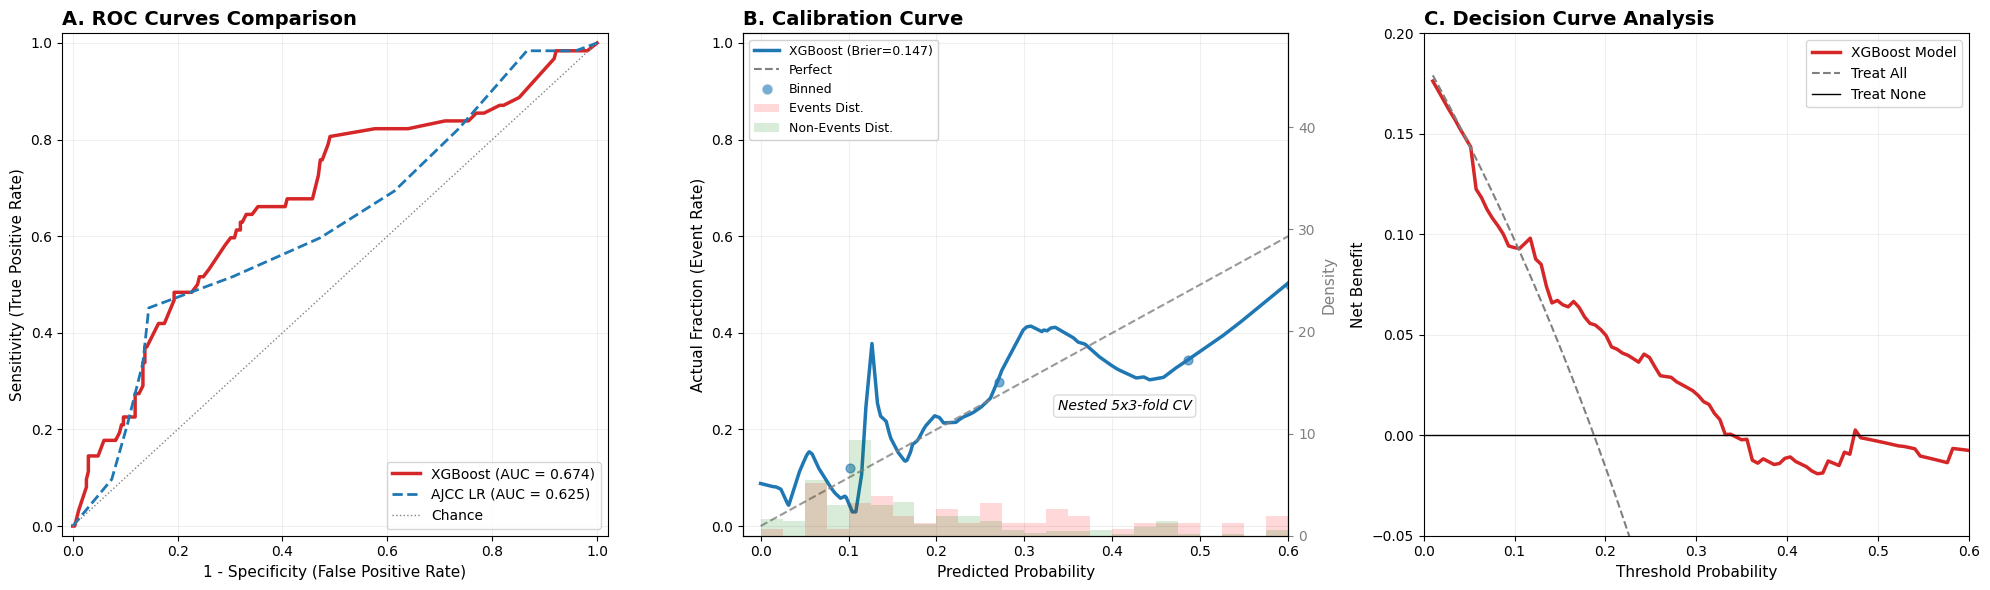

In [405]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score, brier_score_loss
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.calibration import calibration_curve
from statsmodels.nonparametric.smoothers_lowess import lowess

# ==========================================
# 0. 準備資料 (假設 X, y, y_prob_calib_cv 已經在記憶體中)
# ==========================================
# 如果 y_prob_calib_cv (XGBoost 的預測結果) 已經跑完了，我們直接用
# 我們還需要產生 AJCC 的預測結果來畫 ROC 比較圖

#先執行上一個cell來拿到：X_ajcc, lr, cv
print("正在計算 AJCC Logistic Regression 的 CV 預測值 (用於 ROC 比較)...")

# 產生 AJCC 的預測機率 (無洩漏)
y_prob_ajcc = cross_val_predict(lr, X_ajcc, y, cv=cv, method='predict_proba')[:, 1]
auc_ajcc = roc_auc_score(y, y_prob_ajcc)
auc_xgb = roc_auc_score(y, y_prob_calib_cv)

# ==========================================
# 1. 設定畫布 (1 Row, 3 Columns)
# ==========================================
# figsize=(20, 6) 確保每張圖夠寬，不會擠在一起
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
plt.subplots_adjust(wspace=0.3) # 調整子圖之間的間距

# ==========================================
# Panel A: ROC Curves Comparison
# ==========================================
ax1 = axes[0]

# 計算 ROC 數據
fpr_xgb, tpr_xgb, _ = roc_curve(y, y_prob_calib_cv)
fpr_ajcc, tpr_ajcc, _ = roc_curve(y, y_prob_ajcc)

# 畫圖
ax1.plot(fpr_xgb, tpr_xgb, color='#d62728', lw=2.5, label=f'XGBoost (AUC = {auc_xgb:.3f})')
ax1.plot(fpr_ajcc, tpr_ajcc, color='#1f77b4', lw=2, linestyle='--', label=f'AJCC LR (AUC = {auc_ajcc:.3f})')
ax1.plot([0, 1], [0, 1], color='gray', lw=1, linestyle=':', label='Chance')

# 設定樣式
ax1.set_xlim([-0.02, 1.02])
ax1.set_ylim([-0.02, 1.02])
ax1.set_xlabel('1 - Specificity (False Positive Rate)', fontsize=11)
ax1.set_ylabel('Sensitivity (True Positive Rate)', fontsize=11)
ax1.set_title('A. ROC Curves Comparison', fontsize=14, fontweight='bold', loc='left')
ax1.legend(loc="lower right", fontsize=10, frameon=True)
ax1.grid(True, alpha=0.2)

# ==========================================
# Panel B: Calibration Curve (Dual Axis + Lowess)
# ==========================================
ax2 = axes[1]

# 計算數據
brier = brier_score_loss(y, y_prob_calib_cv)
lowess_results = lowess(y, y_prob_calib_cv, frac=0.2, it=0)
x_smooth = lowess_results[:, 0]
y_smooth = lowess_results[:, 1]
prob_true_bin, prob_pred_bin = calibration_curve(y, y_prob_calib_cv, n_bins=5)

# [左軸] 校準曲線
line1, = ax2.plot(x_smooth, y_smooth, color='#1f77b4', lw=2.5, label=f'XGBoost (Lowess)')
line2, = ax2.plot([0, 1], [0, 1], linestyle='--', color='gray', alpha=0.8, label='Perfectly Calibrated')
scatter = ax2.scatter(prob_pred_bin, prob_true_bin, color='#1f77b4', s=40, alpha=0.6, label='Binned (n=5)', zorder=5)

ax2.set_xlabel('Predicted Probability', fontsize=11)
ax2.set_ylabel('Actual Fraction (Event Rate)', fontsize=11)
ax2.set_ylim([-0.02, 1.02])
ax2.set_xlim([-0.02, 0.6]) # 根據您的要求，這裡X軸可以顯示完整，或依照DCA縮短
ax2.set_title('B. Calibration Curve', fontsize=14, fontweight='bold', loc='left')
ax2.grid(True, alpha=0.2)

# [右軸] 直方圖
ax2_twin = ax2.twinx()
ax2_twin.hist(y_prob_calib_cv[y==1], bins=40, range=(0,1), density=True, color='red', alpha=0.15, label='Events')
ax2_twin.hist(y_prob_calib_cv[y==0], bins=40, range=(0,1), density=True, color='green', alpha=0.15, label='Non-Events')
ax2_twin.set_ylim(0, ax2_twin.get_ylim()[1] * 5) # 壓低直方圖
ax2_twin.set_ylabel('Density', fontsize=11, color='gray')
ax2_twin.tick_params(axis='y', colors='gray')

# 合併 Legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='#1f77b4', lw=2.5, label=f'XGBoost (Brier={brier:.3f})'),
    Line2D([0], [0], color='gray', lw=1.5, linestyle='--', label='Perfect'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#1f77b4', markersize=8, alpha=0.6, label='Binned'),
    plt.Rectangle((0,0),1,1, fc="red", alpha=0.15, label='Events Dist.'),
    plt.Rectangle((0,0),1,1, fc="green", alpha=0.15, label='Non-Events Dist.')
]
ax2.legend(handles=legend_elements, loc='upper left', fontsize=9, framealpha=0.9)

# 小字標註
ax2.text(0.7, 0.25, "Nested 5x3-fold CV", transform=ax2.transAxes, fontsize=10, ha='center', style='italic', bbox=dict(facecolor='white', alpha=0.7, edgecolor='#cccccc', boxstyle='round'))

# ==========================================
# Panel C: Decision Curve Analysis (DCA)
# ==========================================
ax3 = axes[2]

# DCA 計算函數
def calculate_net_benefit(y_true, y_prob, thresholds):
    net_benefits = []
    n = len(y_true)
    for pt in thresholds:
        y_pred = y_prob >= pt
        tp = np.sum((y_pred == 1) & (y_true == 1))
        fp = np.sum((y_pred == 1) & (y_true == 0))
        net_benefit = (tp / n) - (fp / n) * (pt / (1 - pt))
        net_benefits.append(net_benefit)
    return np.array(net_benefits)

# 設定閾值 (只畫到 0.6)
thresholds = np.linspace(0.01, 0.6, 100)
nb_model = calculate_net_benefit(y, y_prob_calib_cv, thresholds)
prevalence = np.mean(y)
nb_all = prevalence - (1 - prevalence) * (thresholds / (1 - thresholds))

# 畫圖
ax3.plot(thresholds, nb_model, color='#d62728', lw=2.5, label='XGBoost Model')
ax3.plot(thresholds, nb_all, color='gray', linestyle='--', lw=1.5, label='Treat All')
ax3.axhline(y=0, color='black', linestyle='-', lw=1, label='Treat None')

# 設定樣式
ax3.set_xlim([0, 0.6])
ax3.set_ylim([-0.05, 0.2])
ax3.set_xlabel('Threshold Probability', fontsize=11)
ax3.set_ylabel('Net Benefit', fontsize=11)
ax3.set_title('C. Decision Curve Analysis', fontsize=14, fontweight='bold', loc='left')
ax3.legend(loc='upper right', fontsize=10, frameon=True)
ax3.grid(True, alpha=0.2)

# ==========================================
# 4. 輸出
# ==========================================
plt.tight_layout()
plt.savefig('Figure_2_Model_Performance.tiff', dpi=600, bbox_inches='tight')
plt.savefig('Figure_2_Model_Performance.png', dpi=300, bbox_inches='tight')
plt.show()



### Table 2: AJCC only和XGBoost Model的效能比較
注意這裡的cutoff value是當下算出來的Youden index，而不是之後用全數據訓練出來的模型算出來的

In [406]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
from sklearn.utils import resample
from docx import Document
from docx.shared import Pt
from docx.enum.text import WD_ALIGN_PARAGRAPH

# ==========================================
# 定義計算函數 (動態計算 Cutoff，防止洩漏)
# ==========================================
def get_metrics_and_cutoff(y_true, y_prob):
    # 1. 在當下的數據中，算出最佳 Youden Cutoff
    # 這確保了 Cutoff 也是由驗證數據決定的，而不是從外部偷看
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    j_scores = tpr + (1 - fpr) - 1
    best_idx = np.argmax(j_scores)
    cutoff_cv = thresholds[best_idx]
    
    # 2. 計算 AUC
    auc = roc_auc_score(y_true, y_prob)
    
    # 3. 根據這個 Cutoff 轉成 0/1
    y_pred = (y_prob >= cutoff_cv).astype(int)
    
    # 4. 計算指標
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sens = tp / (tp + fn) if (tp + fn) > 0 else 0
    spec = tn / (tn + fp) if (tn + fp) > 0 else 0
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    
    return {
        "AUC": auc,
        "Sensitivity": sens,
        "Specificity": spec,
        "PPV": ppv,
        "NPV": npv,
        "Cutoff": cutoff_cv  # 回傳這個驗證集專用的 Cutoff
    }

# Bootstrap 計算信賴區間
def get_ci(y_true, y_prob, metric_name, n_boot=1000):
    values = []
    for i in range(n_boot):
        indices = resample(np.arange(len(y_true)), replace=True, random_state=i)
        y_boot_true = y_true.iloc[indices] if hasattr(y_true, 'iloc') else y_true[indices]
        y_boot_prob = y_prob[indices]
        
        try:
            # 在每次 Bootstrap 重抽樣中，重新計算 Cutoff 和指標
            # 這是最嚴格的 CI 計算方式 (Full Uncertainty)
            m = get_metrics_and_cutoff(y_boot_true, y_boot_prob)
            values.append(m[metric_name])
        except:
            continue
            
    lower = np.percentile(values, 2.5)
    upper = np.percentile(values, 97.5)
    return lower, upper

# ==========================================
# 計算並輸出 Table 2
# ==========================================
# 這裡我們使用 Nested CV 跑出來的機率 (y_prob_calib_cv)
# 這代表「模型沒看過這些人」時的表現
models = {
    "AJCC Staging": y_prob_ajcc,
    "XGBoost Model": y_prob_calib_cv
}

results=[]

print(f"{'Model':<15} | {'Cutoff':<8} | {'AUC (95% CI)':<20} | {'Sens (95% CI)':<20} | {'Spec (95% CI)':<20} | {'PPV':<10} | {'NPV':<10}")
print("-" * 120)

for name, probs in models.items():
    # 計算點估計 (Point Estimate)
    m = get_metrics_and_cutoff(y, probs)
    
    # 計算 CI
    auc_lo, auc_hi = get_ci(y, probs, "AUC")
    sens_lo, sens_hi = get_ci(y, probs, "Sensitivity")
    spec_lo, spec_hi = get_ci(y, probs, "Specificity")
    
    # 格式化輸出
    cutoff_str = f"{m['Cutoff']:.3f}"
    auc_str = f"{m['AUC']:.3f} ({auc_lo:.2f}-{auc_hi:.2f})"
    sens_str = f"{m['Sensitivity']:.1%} ({sens_lo:.2%}-{sens_hi:.2%})"
    spec_str = f"{m['Specificity']:.1%} ({spec_lo:.2%}-{spec_hi:.2%})"
    ppv_str = f"{m['PPV']:.1%}"
    npv_str = f"{m['NPV']:.1%}"
    
    print(f"{name:<15} | {cutoff_str:<8} | {auc_str:<20} | {sens_str:<20} | {spec_str:<20} | {ppv_str:<10} | {npv_str:<10}")

# 【關鍵修正】把算好的資料存進 results
    results.append({
        "Model": name,
        "Cutoff": m['Cutoff'],
        "AUC (95% CI)": auc_str,
        "Sensitivity (95% CI)": sens_str,
        "Specificity (95% CI)": spec_str,
        "PPV": ppv_str,
        "NPV": npv_str
    })

cutoff_cv = m['Cutoff']
print("-" * 120)

df_table2 = pd.DataFrame(results)

# 選擇要輸出的欄位
cols_to_export = ['Model', 'Cutoff', 'AUC (95% CI)', 'Sensitivity (95% CI)', 'Specificity (95% CI)', 'PPV', 'NPV']
df_export = df_table2[cols_to_export]

# 2. 建立 Word 文件
doc = Document()

# 加入標題
heading = doc.add_heading('Table 2. Comparison of Predictive Performance', level=1)
heading.alignment = WD_ALIGN_PARAGRAPH.CENTER

# 加入表格 (Rows = 資料列數 + 1標題列, Cols = 欄位數)
table = doc.add_table(rows=len(df_export)+1, cols=len(df_export.columns))
table.style = 'Table Grid' # 加框線

# 填寫標題列 (Header)
hdr_cells = table.rows[0].cells
for i, col_name in enumerate(df_export.columns):
    hdr_cells[i].text = col_name
    hdr_cells[i].paragraphs[0].runs[0].font.bold = True # 粗體

# 填寫數據列 (Data)
for i, row in df_export.iterrows():
    row_cells = table.rows[i+1].cells
    for j, val in enumerate(row):
        # 將數值轉為字串填入
        if isinstance(val, float):
            row_cells[j].text = f"{val:.3f}"
        else:
            row_cells[j].text = str(val)

# 加入註解
doc.add_paragraph('\nNote: 95% Confidence Intervals (CI) were calculated using bootstrap resampling (n=1000).')

# 3. 存檔
#doc.save('Table2_Results.docx')
print("✅ 成功！已產生 Word 檔案：Table2_Results.docx")

Model           | Cutoff   | AUC (95% CI)         | Sens (95% CI)        | Spec (95% CI)        | PPV        | NPV       
------------------------------------------------------------------------------------------------------------------------
AJCC Staging    | 0.715    | 0.625 (0.54-0.70)    | 45.2% (32.81%-58.34%) | 85.5% (80.60%-89.51%) | 41.8%      | 87.1%     
XGBoost Model   | 0.120    | 0.674 (0.59-0.75)    | 80.6% (45.60%-89.06%) | 50.9% (46.86%-85.34%) | 27.5%      | 91.9%     
------------------------------------------------------------------------------------------------------------------------
✅ 成功！已產生 Word 檔案：Table2_Results.docx


畫圖用樣本數 (N): 329
DFS 分析總人數: 329
DFS Events 總數 (復發+死亡): 130
(原本單純復發數: 87)


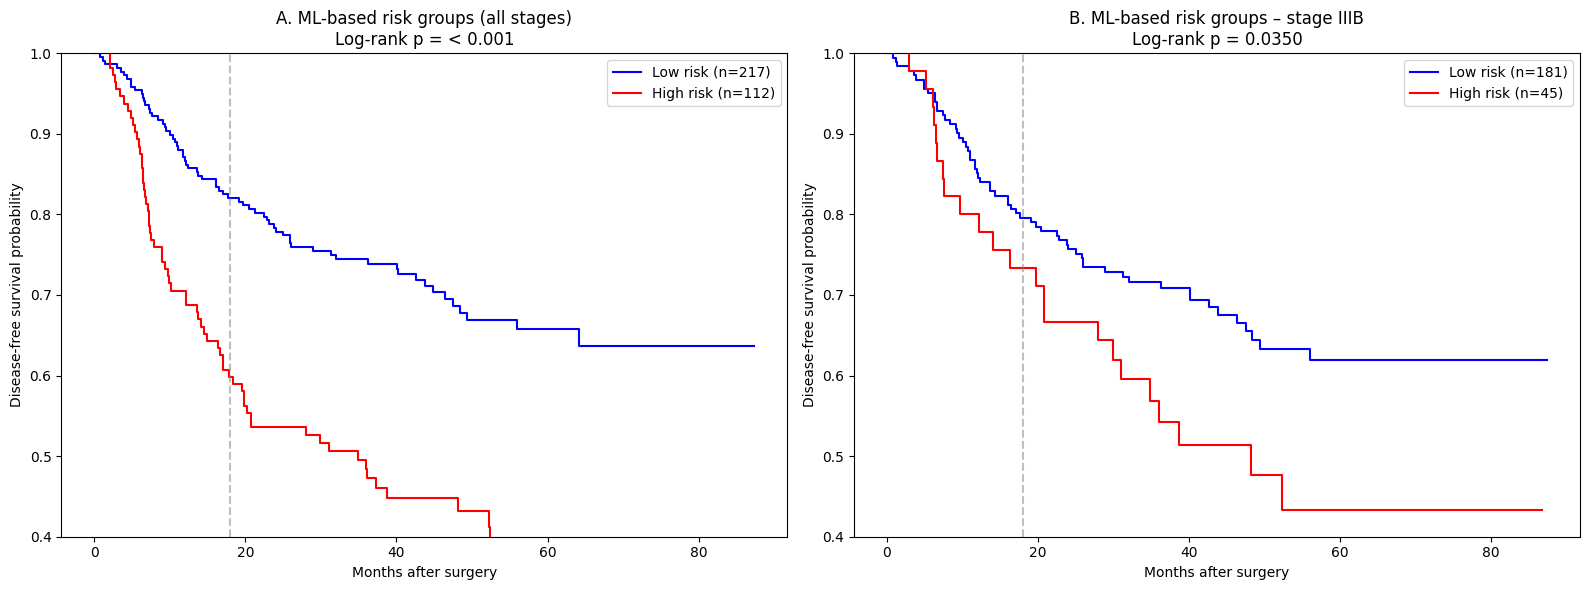

Figure 3A log-rank p (all stages):  < 0.001
Figure 3B log-rank p (stage IIIB): 0.0350


In [410]:
if 'y_prob_calib_cv' not in locals():
    raise ValueError("找不到 y_prob_calib_cv，請確認 Cell 324 (Nested CV) 是否已執行完畢。")

df_train['ML_Prob'] = y_prob_calib_cv

# 【修正步驟 2】現在再從 df_train 產生 df_plot，這樣 ML_Prob 就會自動跟著過去
df_plot = df_train.dropna(subset=['DFS_Months', 'Recurrence']).copy()

print(f"畫圖用樣本數 (N): {len(df_plot)}") # 應該是 329
# 定義 DFS Event：復發或死亡算 event
df_plot['DFS_Event'] = (df_plot['Recurrence'] == 1) | (df_plot['Death'] == 1)
df_plot['DFS_Event'] = df_plot['DFS_Event'].astype(int)

# 移除時間或事件有缺值的
df_plot.dropna(subset=['DFS_Months', 'DFS_Event'], inplace=True)

print(f"DFS 分析總人數: {len(df_plot)}")
print(f"DFS Events 總數 (復發+死亡): {df_plot['DFS_Event'].sum()}")
print(f"(原本單純復發數: {df_plot['Recurrence'].sum()})")

T = df_plot['DFS_Months']
E = df_plot['DFS_Event']

# =====================================================
# Figure 3：ML risk–stratified DFS（Panel A + Panel B）
# =====================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
kmf = KaplanMeierFitter()

# ---------- Panel A：All stages，ML-risk-stratified ----------
ax = axes[0]

high_risk = df_plot['ML_Prob'] >= best_cutoff
low_risk  = df_plot['ML_Prob'] < best_cutoff

# Low risk
kmf.fit(T[low_risk], E[low_risk],
        label=f"Low risk (n={low_risk.sum()})")
kmf.plot_survival_function(ax=ax, color='blue', ci_show=False)

# High risk
kmf.fit(T[high_risk], E[high_risk],
        label=f"High risk (n={high_risk.sum()})")
kmf.plot_survival_function(ax=ax, color='red', ci_show=False)

lr_all = logrank_test(T[low_risk], T[high_risk],
                      E[low_risk], E[high_risk])

ax.set_title(f"A. ML-based risk groups (all stages)\n"
             f"Log-rank p = {format_p(lr_all.p_value)}")
ax.set_xlabel("Months after surgery")
ax.set_ylabel("Disease-free survival probability")
ax.axvline(x=18, color='gray', linestyle='--', alpha=0.5)
ax.set_ylim(0.4, 1.0)

# ---------- Panel B：Stage IIIB，ML-risk-stratified ----------
ax = axes[1]

# 這裡的條件可以依你實際 AJCC_Substage 的寫法微調
subgroup_mask = df_plot['AJCC_Substage'].astype(str).str.contains('B')
df_subgroup = df_plot[subgroup_mask].copy()

high_risk_sub = df_subgroup['ML_Prob'] >= best_cutoff
low_risk_sub  = df_subgroup['ML_Prob'] < best_cutoff

# Low risk (IIIB)
kmf.fit(df_subgroup.loc[low_risk_sub, 'DFS_Months'],
        df_subgroup.loc[low_risk_sub, 'DFS_Event'],
        label=f"Low risk (n={low_risk_sub.sum()})")
kmf.plot_survival_function(ax=ax, color='blue', ci_show=False)

# High risk (IIIB)
kmf.fit(df_subgroup.loc[high_risk_sub, 'DFS_Months'],
        df_subgroup.loc[high_risk_sub, 'DFS_Event'],
        label=f"High risk (n={high_risk_sub.sum()})")
kmf.plot_survival_function(ax=ax, color='red', ci_show=False)

lr_sub = logrank_test(
    df_subgroup.loc[low_risk_sub,  'DFS_Months'],
    df_subgroup.loc[high_risk_sub, 'DFS_Months'],
    df_subgroup.loc[low_risk_sub,  'DFS_Event'],
    df_subgroup.loc[high_risk_sub, 'DFS_Event']
)

ax.set_title(f"B. ML-based risk groups – stage IIIB\n"
             f"Log-rank p = {format_p(lr_sub.p_value)}")
ax.set_xlabel("Months after surgery")
ax.set_ylabel("Disease-free survival probability")
ax.axvline(x=18, color='gray', linestyle='--', alpha=0.5)
ax.set_ylim(0.4, 1.0)

plt.tight_layout()
plt.savefig("figure3_ML_risk_DFS.tiff", dpi=600, format='tiff')
plt.show()

print(f"Figure 3A log-rank p (all stages):  {format_p(lr_all.p_value)}")
print(f"Figure 3B log-rank p (stage IIIB): {format_p(lr_sub.p_value)}")

### 剛剛已經用Nested CV驗證完了，所以現在要來產出Web Tool用的最終模型

訓練集樣本數 (N): 331
✅ 已儲存 feature_columns -> final_feature_columns.pkl
正在訓練 Pipeline (包含 KNN 補值與機率校準)...
✅ 已儲存 KNNImputer -> final_knn_imputer.pkl
✅ 包含補值功能的完整 Pipeline 已儲存為 'final_model_calibrated.pkl'

【最終參數】
Training AUC: 0.7966
Best Cutoff (Youden): 0.1991
畫圖用樣本數 (N): 329
DFS 分析總人數: 329
DFS Events 總數 (復發+死亡): 130
(原本單純復發數: 87)


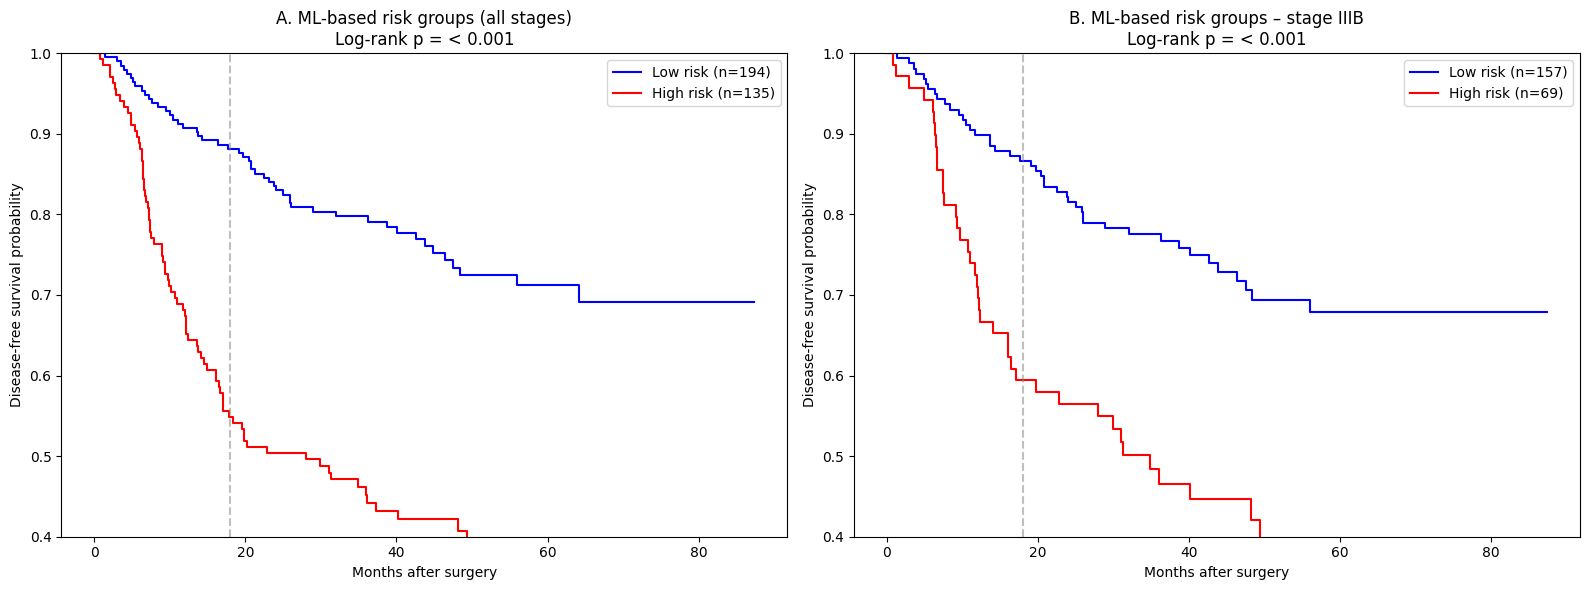

Figure 3A log-rank p (all stages):  < 0.001
Figure 3B log-rank p (stage IIIB): < 0.001


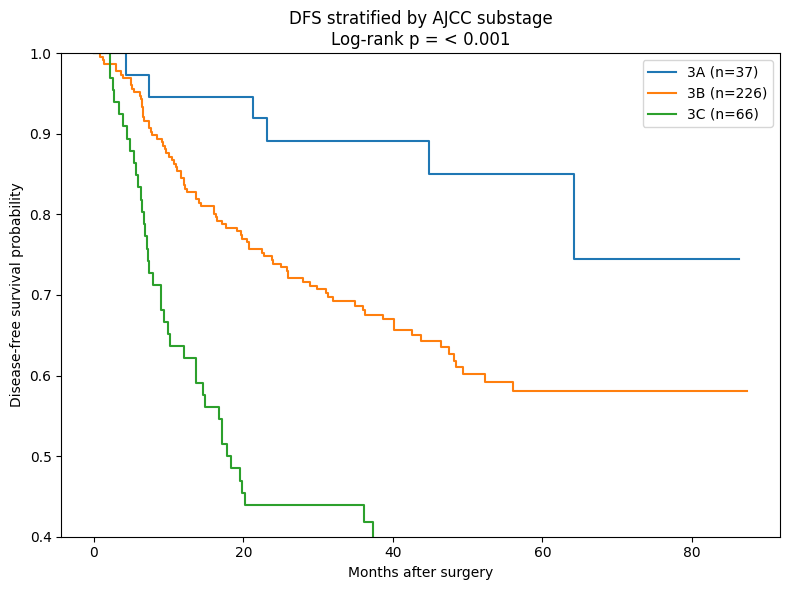

AJCC DFS log-rank p (Figure S2): < 0.001


In [408]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.impute import KNNImputer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test, multivariate_logrank_test
import joblib

# 讀取資料
df = pd.read_parquet('all_cases_prepared_for_ML.parquet', engine='pyarrow')

def format_p(p):
    if p < 0.001:
        return "< 0.001"
    else:
        return f"{p:.4f}"

# ==========================================
# 1. 準備全量數據
# ==========================================
features = ['AJCC_Substage', 'PNI', 'LNR', 'Differentiation']

# 確保時間與事件存在
cols_needed = features + ['edr_18m', 'DFS_Months', 'Recurrence', 'Death']
df_clean = df[cols_needed].copy()

# 只刪除沒有 Target (edr_18m) 的資料
df_train = df_clean.dropna(subset=['edr_18m']).copy()

X = df_train[features].copy()
y = df_train['edr_18m'].astype(int)

print(f"訓練集樣本數 (N): {len(X)}")

# --- 前處理 (Preprocessing) ---
# 1. 轉數值
X['PNI'] = pd.to_numeric(X['PNI'], errors='coerce')
X['Differentiation'] = pd.to_numeric(X['Differentiation'], errors='coerce')

# 2. One-Hot Encoding (手動處理確保 App 端一致性)
# 這裡我們在 Pipeline 之外處理 One-Hot，因為這屬於特徵工程的一環
# App 端也必須送入這三個欄位
X = pd.get_dummies(X, columns=['AJCC_Substage'])

# 3. 清洗無限大
X.replace([np.inf, -np.inf], np.nan, inplace=True)

feature_columns = X.columns.tolist()
joblib.dump(feature_columns, 'final_feature_columns.pkl')
print("✅ 已儲存 feature_columns -> final_feature_columns.pkl")

# 注意：這裡不再先做 fit_transform，而是把 Imputer 定義好放進 Pipeline
# X 現在是可以包含 NaN 的

# ==========================================
# 2. 建立並訓練最終 Pipeline
# ==========================================
ratio = float(y.value_counts()[0] / y.value_counts()[1])

# (A) 定義基礎 XGBoost
xgb_base = XGBClassifier(
    n_estimators=50,
    max_depth=3,
    learning_rate=0.005,
    min_child_weight=1,
    gamma=1,
    subsample=0.8,
    colsample_bytree=0.5,
    reg_lambda=1,
    reg_alpha=0.5,
    scale_pos_weight=ratio,
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=8251,
    n_jobs=-1
)


# (B) 定義校準器
# cv=5 表示內部切 5 份來學校準參數
calibrated_clf = CalibratedClassifierCV(xgb_base, method='isotonic', cv=5)

# (C) 【關鍵修正】建立 Pipeline (補值 -> 校準預測)
final_pipeline = Pipeline([
    ('imputer', KNNImputer(n_neighbors=5)),  # 步驟 1: 補值
    ('model', calibrated_clf)                # 步驟 2: 校準後的模型
])

print("正在訓練 Pipeline (包含 KNN 補值與機率校準)...")
# 直接把含有缺值的 X 丟進去，Pipeline 會自動處理
final_pipeline.fit(X, y)

fitted_imputer = final_pipeline.named_steps['imputer']
joblib.dump(fitted_imputer, 'final_knn_imputer.pkl')
print("✅ 已儲存 KNNImputer -> final_knn_imputer.pkl")

# (D) 預測 (使用訓練好的 Pipeline)
y_pred_prob = final_pipeline.predict_proba(X)[:, 1]

# 將校準後的機率存回 df_train
df_train['ML_Prob'] = y_pred_prob

# (E) 儲存 Pipeline (這才是真正要給 App 用的檔案)
joblib.dump(final_pipeline, 'final_model_calibrated.pkl')
print("✅ 包含補值功能的完整 Pipeline 已儲存為 'final_model_calibrated.pkl'")


# ==========================================
# 3. 重算 Cutoff
# ==========================================
fpr, tpr, thresholds = roc_curve(y, y_pred_prob)
j_scores = tpr + (1 - fpr) - 1
best_idx = np.argmax(j_scores)
best_cutoff = thresholds[best_idx]

print(f"\n【最終參數】")
print(f"Training AUC: {roc_auc_score(y, y_pred_prob):.4f}")
print(f"Best Cutoff (Youden): {best_cutoff:.4f}")

# ==========================================
# 4. 畫圖階段 (KM Plot)
# ==========================================
df_plot = df_train.dropna(subset=['DFS_Months', 'Recurrence']).copy()
print(f"畫圖用樣本數 (N): {len(df_plot)}")

# 定義 DFS Event：復發或死亡算 event
df_plot['DFS_Event'] = (df_plot['Recurrence'] == 1) | (df_plot['Death'] == 1)
df_plot['DFS_Event'] = df_plot['DFS_Event'].astype(int)

# 移除時間或事件有缺值的
df_plot.dropna(subset=['DFS_Months', 'DFS_Event'], inplace=True)

print(f"DFS 分析總人數: {len(df_plot)}")
print(f"DFS Events 總數 (復發+死亡): {df_plot['DFS_Event'].sum()}")
print(f"(原本單純復發數: {df_plot['Recurrence'].sum()})")

T = df_plot['DFS_Months']
E = df_plot['DFS_Event']

# =====================================================
# Figure 3：ML risk–stratified DFS（Panel A + Panel B）
# =====================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
kmf = KaplanMeierFitter()

# ---------- Panel A：All stages，ML-risk-stratified ----------
ax = axes[0]

high_risk = df_plot['ML_Prob'] >= best_cutoff
low_risk  = df_plot['ML_Prob'] < best_cutoff

# Low risk
kmf.fit(T[low_risk], E[low_risk],
        label=f"Low risk (n={low_risk.sum()})")
kmf.plot_survival_function(ax=ax, color='blue', ci_show=False)

# High risk
kmf.fit(T[high_risk], E[high_risk],
        label=f"High risk (n={high_risk.sum()})")
kmf.plot_survival_function(ax=ax, color='red', ci_show=False)

lr_all = logrank_test(T[low_risk], T[high_risk],
                      E[low_risk], E[high_risk])

ax.set_title(f"A. ML-based risk groups (all stages)\n"
             f"Log-rank p = {format_p(lr_all.p_value)}")
ax.set_xlabel("Months after surgery")
ax.set_ylabel("Disease-free survival probability")
ax.axvline(x=18, color='gray', linestyle='--', alpha=0.5)
ax.set_ylim(0.4, 1.0)

# ---------- Panel B：Stage IIIB，ML-risk-stratified ----------
ax = axes[1]

# 這裡的條件可以依你實際 AJCC_Substage 的寫法微調
subgroup_mask = df_plot['AJCC_Substage'].astype(str).str.contains('B')
df_subgroup = df_plot[subgroup_mask].copy()

high_risk_sub = df_subgroup['ML_Prob'] >= best_cutoff
low_risk_sub  = df_subgroup['ML_Prob'] < best_cutoff

# Low risk (IIIB)
kmf.fit(df_subgroup.loc[low_risk_sub, 'DFS_Months'],
        df_subgroup.loc[low_risk_sub, 'DFS_Event'],
        label=f"Low risk (n={low_risk_sub.sum()})")
kmf.plot_survival_function(ax=ax, color='blue', ci_show=False)

# High risk (IIIB)
kmf.fit(df_subgroup.loc[high_risk_sub, 'DFS_Months'],
        df_subgroup.loc[high_risk_sub, 'DFS_Event'],
        label=f"High risk (n={high_risk_sub.sum()})")
kmf.plot_survival_function(ax=ax, color='red', ci_show=False)

lr_sub = logrank_test(
    df_subgroup.loc[low_risk_sub,  'DFS_Months'],
    df_subgroup.loc[high_risk_sub, 'DFS_Months'],
    df_subgroup.loc[low_risk_sub,  'DFS_Event'],
    df_subgroup.loc[high_risk_sub, 'DFS_Event']
)

ax.set_title(f"B. ML-based risk groups – stage IIIB\n"
             f"Log-rank p = {format_p(lr_sub.p_value)}")
ax.set_xlabel("Months after surgery")
ax.set_ylabel("Disease-free survival probability")
ax.axvline(x=18, color='gray', linestyle='--', alpha=0.5)
ax.set_ylim(0.4, 1.0)

plt.tight_layout()
#plt.savefig("Figure3_ML_risk_DFS_apparent.tiff", dpi=600, format='tiff')
plt.show()

print(f"Figure 3A log-rank p (all stages):  {format_p(lr_all.p_value)}")
print(f"Figure 3B log-rank p (stage IIIB): {format_p(lr_sub.p_value)}")

# ================================================
# Figure S2：AJCC-stratified DFS KM (Supplement)
# ================================================
fig, ax = plt.subplots(figsize=(8, 6))
kmf = KaplanMeierFitter()

for group in sorted(df_plot['AJCC_Substage'].dropna().unique()):
    mask = df_plot['AJCC_Substage'] == group
    if mask.sum() > 0:
        kmf.fit(T[mask], E[mask], label=f"{group} (n={mask.sum()})")
        kmf.plot_survival_function(ax=ax, ci_show=False)

results_ajcc = multivariate_logrank_test(T,
                                         df_plot['AJCC_Substage'],
                                         E)

ax.set_title(f"DFS stratified by AJCC substage\n"
             f"Log-rank p = {format_p(results_ajcc.p_value)}")
ax.set_xlabel("Months after surgery")
ax.set_ylabel("Disease-free survival probability")
ax.set_ylim(0.4, 1.0)

plt.tight_layout()
plt.savefig("figureS2_AJCC_DFS.tiff", dpi=300, format='tiff')
plt.show()

print(f"AJCC DFS log-rank p (Figure S2): {format_p(results_ajcc.p_value)}")

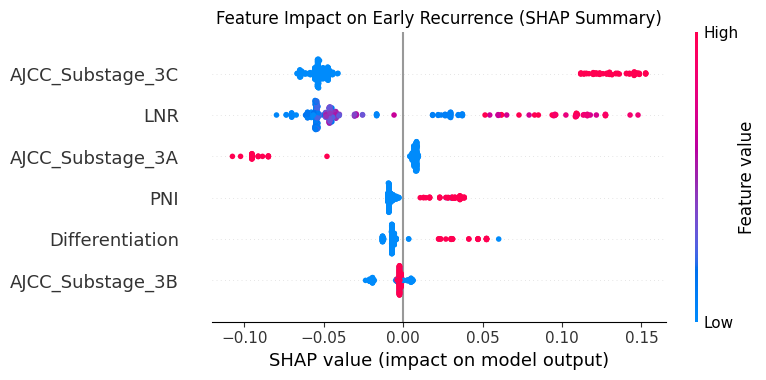

In [409]:
import shap
import matplotlib.pyplot as plt

xgb_base.fit(X_imputed, y)

# 計算 SHAP 值
explainer = shap.TreeExplainer(xgb_base)
shap_values = explainer.shap_values(X_imputed)

# 3. 畫圖
plt.figure(figsize=(10, 8))
plt.title("Feature Impact on Early Recurrence (SHAP Summary)")
shap.summary_plot(shap_values, X_imputed, show=False)

# 調整一下排版讓字不被切掉
plt.tight_layout()
plt.savefig('Figure_4_SHAP_Plot_XGB.tiff', format='tiff', dpi=600)
plt.show()